# Predicting Forest Fire Prevalence Based on Rising Temperatures in the State of Michigan, USA

###Members:
Joseph Vanliew

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import to_datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Data Preprocessing

Original Data Sources Links:

*   **Fire Data**  https://www.kaggle.com/datasets/rtatman/188-million-us-wildfires/data


Important Features Descriptions
1.   FIRE_SIZE = Estimate of acres within the final perimeter of the fire.
2.   FIRE_SIZE_CLASS = Code for fire size based on the number of acres within the final fire perimeter expenditures (A=greater than 0 but less than or equal to 0.25 acres, B=0.26-9.9 acres,
     C=10.0-99.9 acres, D=100-299 acres, E=300 to 999 acres, F=1000 to 4999 acres, and G=5000+ acres).
3.   FIPS_NAME = County name from the FIPS publication 6-4 for representation of counties and equivalent entities.
4.   CONT_DATE = Date on which the fire was declared contained or otherwise controlled (mm/dd/yyyy where mm=month, dd=day, and yyyy=year).
5.   CONT_DOY = Day of year on which the fire was declared contained or otherwise controlled.
6.   STAT_CAUSE_CODE = Code for the (statistical) cause of the fire.
7.   DISCOVERY_DATE = Date on which the fire was discovered or confirmed to exist.


*   **Temperature Data** https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/global/time-series/northAmerica/land/ytd/0/1940-2024?filter=true&filterType=binomial
*   **Extreme Temperature** https://mitracking.state.mi.us/

### Importing Data





In [87]:
#Extreme Heat Days (Yearly)
extreme_heat_days_df = pd.read_csv('Data/Extreme_Heat_Days_By_County.csv')
#Average Monthly Temperature For All of Michigan
average_monthly_temp_df = pd.read_csv('Data/Average_Michigan_Monthly_Temperature.csv', skiprows=4) # first 4 rows have multi-column headers we don't need
#Fire Dataset import
fire_data_df = pd.read_csv('Data/Fires_MI.csv')

### Fire Data Preprocessing

In [88]:
columns_to_drop = [
    'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM', 'NWCG_REPORTING_AGENCY',
    'NWCG_REPORTING_UNIT_ID', 'NWCG_REPORTING_UNIT_NAME',
    'SOURCE_REPORTING_UNIT', 'SOURCE_REPORTING_UNIT_NAME',
    'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID',
    'MTBS_FIRE_NAME', 'COMPLEX_NAME', 'DISCOVERY_TIME',
    'CONT_DATE', 'CONT_DOY', 'CONT_TIME', 'OWNER_CODE',
    'OWNER_DESCR', 'Shape','COUNTY','FIPS_CODE', 'DISCOVERY_DOY',
    'FIRE_SIZE_CLASS','LOCAL_INCIDENT_ID','LOCAL_FIRE_REPORT_ID'
]

fire_data_df.drop(columns=columns_to_drop, inplace=True)

In [89]:
# Convert Julian dates in the DISCOVERY_DATE column to Gregorian dates
fire_data_df['DISCOVERY_DATE'] = to_datetime(fire_data_df['DISCOVERY_DATE'], origin='julian', unit='D')

# Format the Gregorian dates as MM/YYYY to match monthly temperature
fire_data_df['DISCOVERY_DATE'] = fire_data_df['DISCOVERY_DATE'].dt.strftime('%d/%m/%Y')


In [90]:
fire_data_df.rename(columns={'FIPS_NAME': 'COUNTY'}, inplace=True)
print('Years:',fire_data_df.FIRE_YEAR.min(),'->',fire_data_df.FIRE_YEAR.max())

Years: 1992 -> 2015


In [91]:
fire_data_df.head(3)

,OBJECTID,FOD_ID,FPA_ID,FIRE_CODE,FIRE_NAME,FIRE_YEAR,DISCOVERY_DATE,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,FIRE_SIZE,LATITUDE,LONGITUDE,STATE,COUNTY
0,2215,2230,FS-1423712,BE1X,DITLOW FIRE,2005,01/04/2005,5.0,Debris Burning,2.0,43.571111,-85.979167,MI,Newaygo
1,2324,2339,FS-1424005,BNC2,UNDERWOOD HILL FIRE,2005,11/04/2005,2.0,Equipment Use,66.0,43.944167,-82.990278,MI,Lake
2,2336,2351,FS-1424035,BE1X,COOPER FIRE,2005,13/04/2005,9.0,Miscellaneous,1.5,43.430000,-85.806667,MI,Newaygo


In [92]:
# Handle nulls in 'FIRE_CODE'
fire_data_df['FIRE_CODE'] = fire_data_df['FIRE_CODE'].fillna('Unknown')

# Handle nulls in 'FIRE_NAME'
fire_data_df['FIRE_NAME'] = fire_data_df['FIRE_NAME'].fillna('No Name')

# Drop rows where 'COUNTY' column values are null
fire_data_df = fire_data_df.dropna(subset=['COUNTY'])


In [93]:
print(fire_data_df.isnull().sum())

OBJECTID            0
FOD_ID              0
FPA_ID              0
FIRE_CODE           0
FIRE_NAME           0
FIRE_YEAR           0
DISCOVERY_DATE      0
STAT_CAUSE_CODE     0
STAT_CAUSE_DESCR    0
FIRE_SIZE           0
LATITUDE            0
LONGITUDE           0
STATE               0
COUNTY              0
dtype: int64


In [94]:
print(extreme_heat_days_df.isnull().sum())

County                         0
Year(s)                        0
Number of Extreme Heat Days    0
dtype: int64


In [95]:
print(average_monthly_temp_df.isnull().sum())

Date       0
Value      0
Anomaly    0
dtype: int64


In [96]:
final_df = fire_data_df
#indexing by Discovery_Date, preparing for stationary data analysis with an Augmented Dickey-Fuller test
final_df.DISCOVERY_DATE = pd.to_datetime(final_df.DISCOVERY_DATE, format = '%d/%m/%Y')
final_df.set_index("DISCOVERY_DATE", inplace=True)
final_df.head(3)

,OBJECTID,FOD_ID,FPA_ID,FIRE_CODE,FIRE_NAME,FIRE_YEAR,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,FIRE_SIZE,LATITUDE,LONGITUDE,STATE,COUNTY
DISCOVERY_DATE,,,,,,,,,,,,,
2005-04-01,2215,2230,FS-1423712,BE1X,DITLOW FIRE,2005,5.0,Debris Burning,2.0,43.571111,-85.979167,MI,Newaygo
2005-04-11,2324,2339,FS-1424005,BNC2,UNDERWOOD HILL FIRE,2005,2.0,Equipment Use,66.0,43.944167,-82.990278,MI,Lake
2005-04-13,2336,2351,FS-1424035,BE1X,COOPER FIRE,2005,9.0,Miscellaneous,1.5,43.430000,-85.806667,MI,Newaygo


In [97]:
first_index_str = final_df.index[0].strftime('%Y-%m-%d')
print(first_index_str)

2005-04-01


## Exploratory Data Analysis

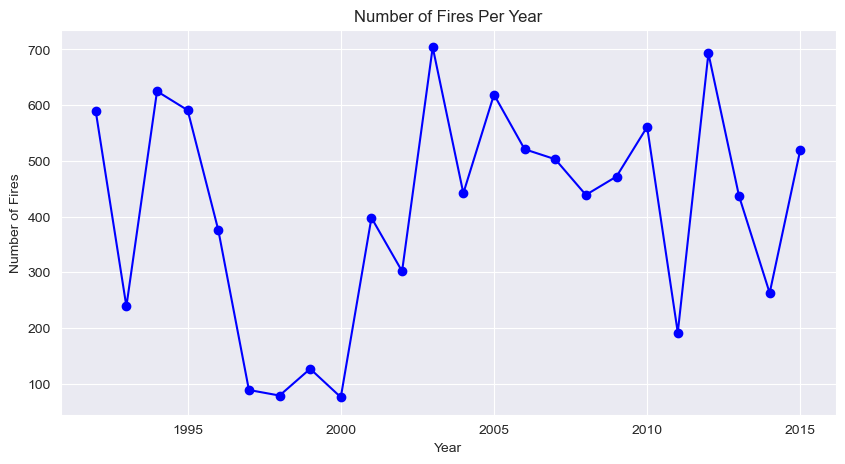

In [98]:
fires_per_year = final_df.groupby('FIRE_YEAR').size()
fires_per_year.plot(kind='line', figsize=(10, 5), marker='o', linestyle='-', color='b')
plt.title('Number of Fires Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Fires')
plt.grid(True)
plt.show()

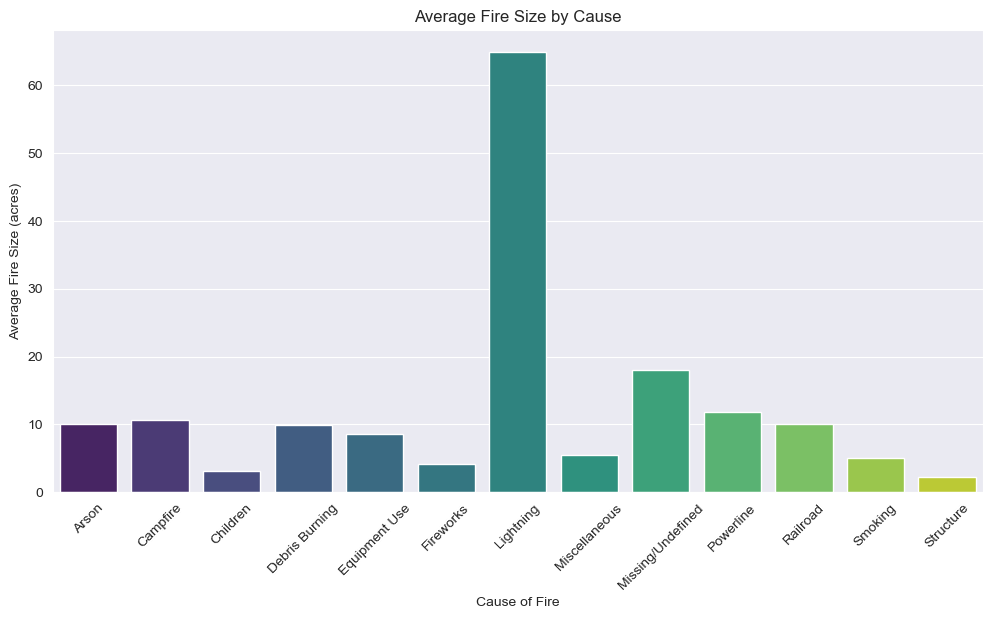

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the average fire size for each cause
average_fire_size_by_cause = final_df.groupby('STAT_CAUSE_DESCR')['FIRE_SIZE'].mean().reset_index()

# Create the bar plot
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(x='STAT_CAUSE_DESCR', y='FIRE_SIZE', data=average_fire_size_by_cause, palette='viridis', hue='STAT_CAUSE_DESCR', legend=False)
plt.title('Average Fire Size by Cause')
plt.xlabel('Cause of Fire')
plt.ylabel('Average Fire Size (acres)')
plt.xticks(rotation=45)
plt.show()

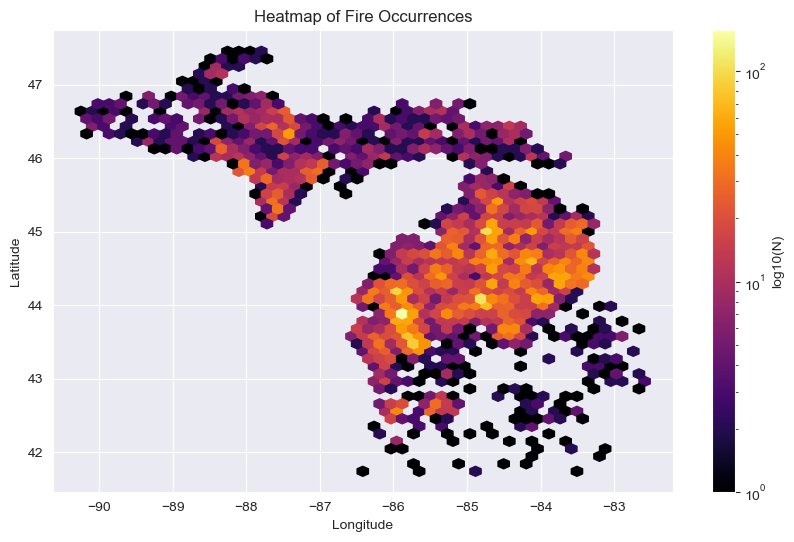

In [100]:

plt.figure(figsize=(10, 6))
hb = plt.hexbin(final_df['LONGITUDE'], final_df['LATITUDE'], gridsize=50, cmap='inferno', bins='log')
plt.colorbar(hb, label='log10(N)')
plt.title('Heatmap of Fire Occurrences')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

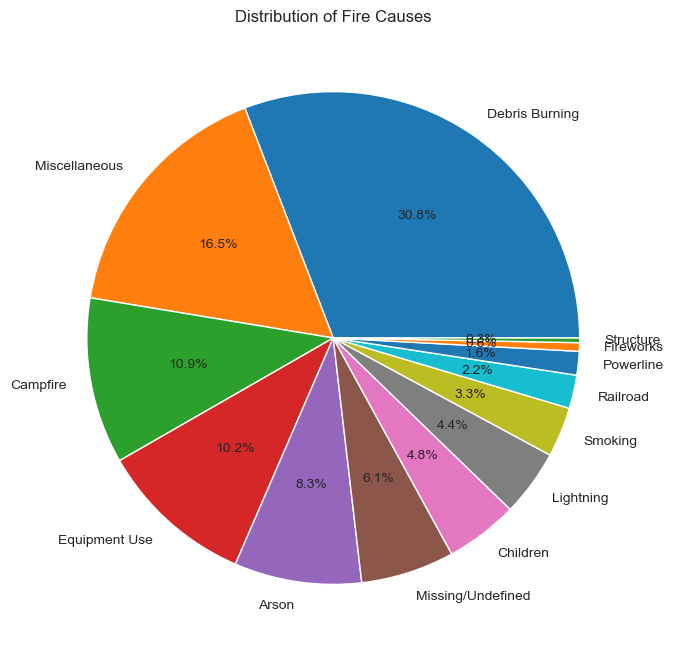

In [101]:
cause_counts = final_df['STAT_CAUSE_DESCR'].value_counts()
plt.figure(figsize=(12, 8))
cause_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Fire Causes')
plt.ylabel('')
plt.show()

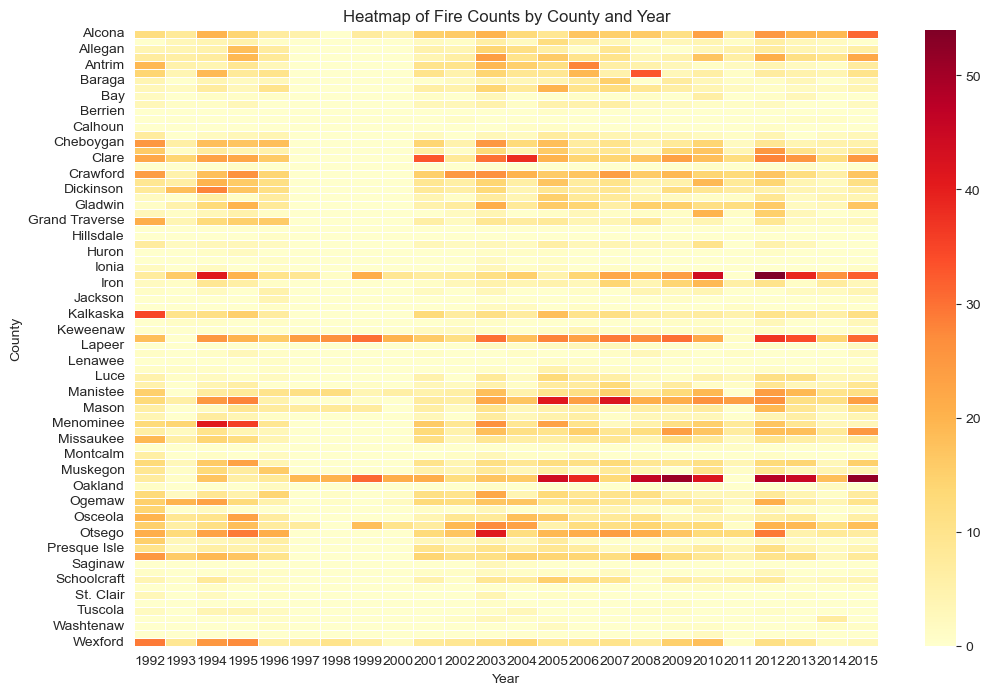

In [102]:
# Creating a pivot table for the heatmap
heatmap_data = final_df.pivot_table(values='OBJECTID', index='COUNTY', columns='FIRE_YEAR', aggfunc='count', fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='YlOrRd', linewidths=.5)
plt.title('Heatmap of Fire Counts by County and Year')
plt.xlabel('Year')
plt.ylabel('County')
plt.show()

Should be worth noting the lack of fire data between the beginning of 97 and the end of 2000

## Modeling



In [103]:
from statsmodels.tsa.stattools import adfuller

In [104]:
#Augmented Dickey-Fuller test for stationary checking

monthly_fire_counts = final_df.resample('ME').size()

adf_result = adfuller(monthly_fire_counts)

print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

if adf_result[1] < 0.05:
    print("The time series is stationary. Approved for ARIMA models")
else:
    print("The time series is not stationary.")

ADF Statistic: -3.036582
p-value: 0.031616
Critical Values:
	1%: -3.455
	5%: -2.872
	10%: -2.572
The time series is stationary. Approved for ARIMA models


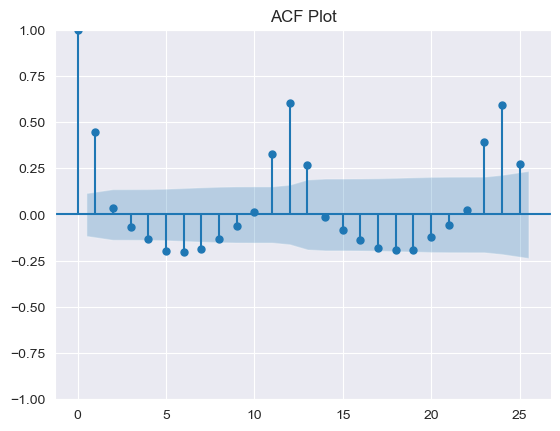

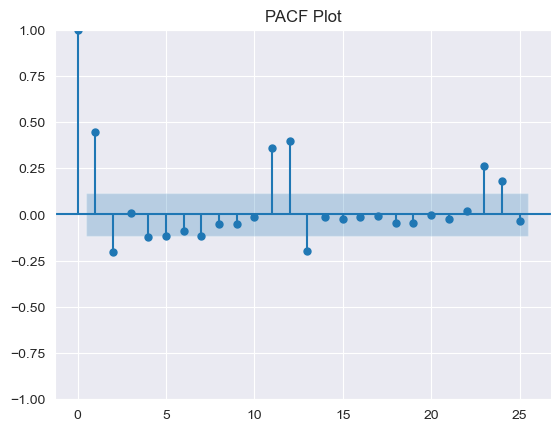

In [105]:
# To help with determining non-seasonal (p, d, q) and seasonal (P , D, Q, s) parameters for a SARIMAX model... s: for seasonality (year)
#AutoCorrelation Function corresponding to (p,d,q) values to SARIMAX
plot_acf(monthly_fire_counts)
plt.title('ACF Plot')
plt.show()
#Partial Auto Correlation Function corresponding to (P,D,Q,s) values for SARIMAX
plot_pacf(monthly_fire_counts)
plt.title('PACF Plot')
plt.show()

In [110]:
# Fourier terms to simplify seasonal parameters and make processing less computationally expensive, as opposed to just plugging 365 days into the seasonal orders
monthly_fire_counts_log = np.log1p(monthly_fire_counts)
N = len(monthly_fire_counts_log)
t = np.arange(N)

s = 12  #yearly seasonality

# number of harmonics, K, is a hyper-perammeter can be fine-tuned remember to match before visualizing data below
K = 16

#Processing Fourier Terms
fourier_terms = np.column_stack([
    np.sin(2 * np.pi * (k+1) * t / s) for k in range(K)] +
    [np.cos(2 * np.pi * (k+1) * t / s) for k in range(K)]
)

n_splits = 4
n_samples = len(monthly_fire_counts_log) #length of our samples from data
min_train_size = int(n_samples * 0.35) #setting aside 35% of our data for training purposes
test_size = (n_samples - min_train_size) // n_splits #separating out our testing data
start_train_size = n_samples - test_size * n_splits #making sure we don't use training data from our splits.

#Printing for referencing during execution
print("------------------------------------------------------")
print("TRAINING AND TEST DATA:")
print("------------------------------------------------------")
print("Number of splits:", n_splits)
print("Total samples:", n_samples)
print("Test size per split:", test_size)
print("Start train size:", start_train_size)

# SARIMAX Model parameters
p, d, q = 1, 0, 1  # Non-seasonal orders
P, D, Q, s = 1, 0, 1, 12  # Seasonal orders may need to adjust more if our fourier terms don't accurately capture spikes.

error_scores = []
predictions = []
actuals = []
mse_scores = []
rmse_scores = []
mae_scores = []

print("------------------------------------------------------")
print("SEQUENTIAL CROSS VALIDATION/SARIMAX MODEL:")
print("------------------------------------------------------")

# Sequential-Cross-Validation
for i in range(n_splits):
    # Train
    end_train = start_train_size + i * test_size # getting the end of our training data
    train = monthly_fire_counts_log.iloc[:end_train]
    test = monthly_fire_counts_log.iloc[end_train:end_train + test_size]
    fourier_train = fourier_terms[:end_train, :]
    fourier_test = fourier_terms[end_train:end_train + test_size, :]

    # Ensure 'train' is one-dimensional
    if len(train.shape) > 1:
      train = train.ravel()  # Flattens the array to 1D if it is not already

    # Check 'fourier_train'
    if len(fourier_train.shape) == 1:
      fourier_train = fourier_train.reshape(-1, 1)

    print("Train shape:", train.shape)  # Ensure (n,)
    print("Fourier train shape:", fourier_train.shape)  #Ensure (n, 2k)

    # Fit the SARIMA model
    model = SARIMAX(train, exog=fourier_train, order=(p, d, q),
                    seasonal_order=(P, D, Q, s),
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    
    print(model_fit.summary())

    # Forecast
    forecasted_log = model_fit.get_forecast(steps=len(test), exog=fourier_test).predicted_mean


    forecasted_values = np.expm1(forecasted_log)
    forecasted_values = np.maximum(forecasted_values, 0)  # Ensure non-negative predictions

    # Inverse transform actual logged values for error metrics
    actual_values = np.expm1(test.values)

    # values and forecasts
    predictions.append(forecasted_values)
    actuals.append(actual_values)

    # Calculate metrics
    mse = mean_squared_error(actual_values, forecasted_values)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_values, forecasted_values)

    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mae_scores.append(mae)

# Calculate mean metrics across all folds
mean_mse = np.mean(mse_scores)
mean_rmse = np.mean(rmse_scores)
mean_mae = np.mean(mae_scores)

# Output
print(f'-----------------------------------------------')
print(f'Mean MSE over all folds: {mean_mse}')
print(f'Mean RMSE over all folds: {mean_rmse}')
print(f'Mean MAE over all folds: {mean_mae}')

------------------------------------------------------
TRAINING AND TEST DATA:
------------------------------------------------------
Number of splits: 4
Total samples: 286
Test size per split: 46
Start train size: 102
------------------------------------------------------
SEQUENTIAL CROSS VALIDATION/SARIMAX MODEL:
------------------------------------------------------
Train shape: (102,)
Fourier train shape: (102, 32)


/Users/josephvanliew/anaconda3/envs/FireOccurance/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  102
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -105.098
Date:                            Mon, 07 Oct 2024   AIC                            284.196
Time:                                    15:42:31   BIC                            375.857
Sample:                                02-29-1992   HQIC                           321.124
                                     - 07-31-2000                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -1.392e+13      0.072  -1.93e+14      0.000   -1.39e+13   -1.39e+13
x2          2.429e+13      0.054   

/Users/josephvanliew/anaconda3/envs/FireOccurance/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  148
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -153.590
Date:                            Mon, 07 Oct 2024   AIC                            381.181
Time:                                    15:42:31   BIC                            488.401
Sample:                                02-29-1992   HQIC                           424.751
                                     - 05-31-2004                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -3.145e+12      0.069  -4.54e+13      0.000   -3.15e+12   -3.15e+12
x2           7.13e+12      0.043   

/Users/josephvanliew/anaconda3/envs/FireOccurance/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  194
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -201.989
Date:                            Mon, 07 Oct 2024   AIC                            477.978
Time:                                    15:42:32   BIC                            596.118
Sample:                                02-29-1992   HQIC                           525.879
                                     - 03-31-2008                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          2.384e+12      0.063   3.81e+13      0.000    2.38e+12    2.38e+12
x2          1.232e+12      0.040   

/Users/josephvanliew/anaconda3/envs/FireOccurance/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  240
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -253.838
Date:                            Mon, 07 Oct 2024   AIC                            581.676
Time:                                    15:42:32   BIC                            708.236
Sample:                                02-29-1992   HQIC                           632.750
                                     - 01-31-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          1.864e+12      0.049   3.83e+13      0.000    1.86e+12    1.86e+12
x2          1.352e+12      0.033   

Unstable model results may be due to multicollinearity of the fourier terms. A VIF should be run on them in the future to determine how to lower coefficients.

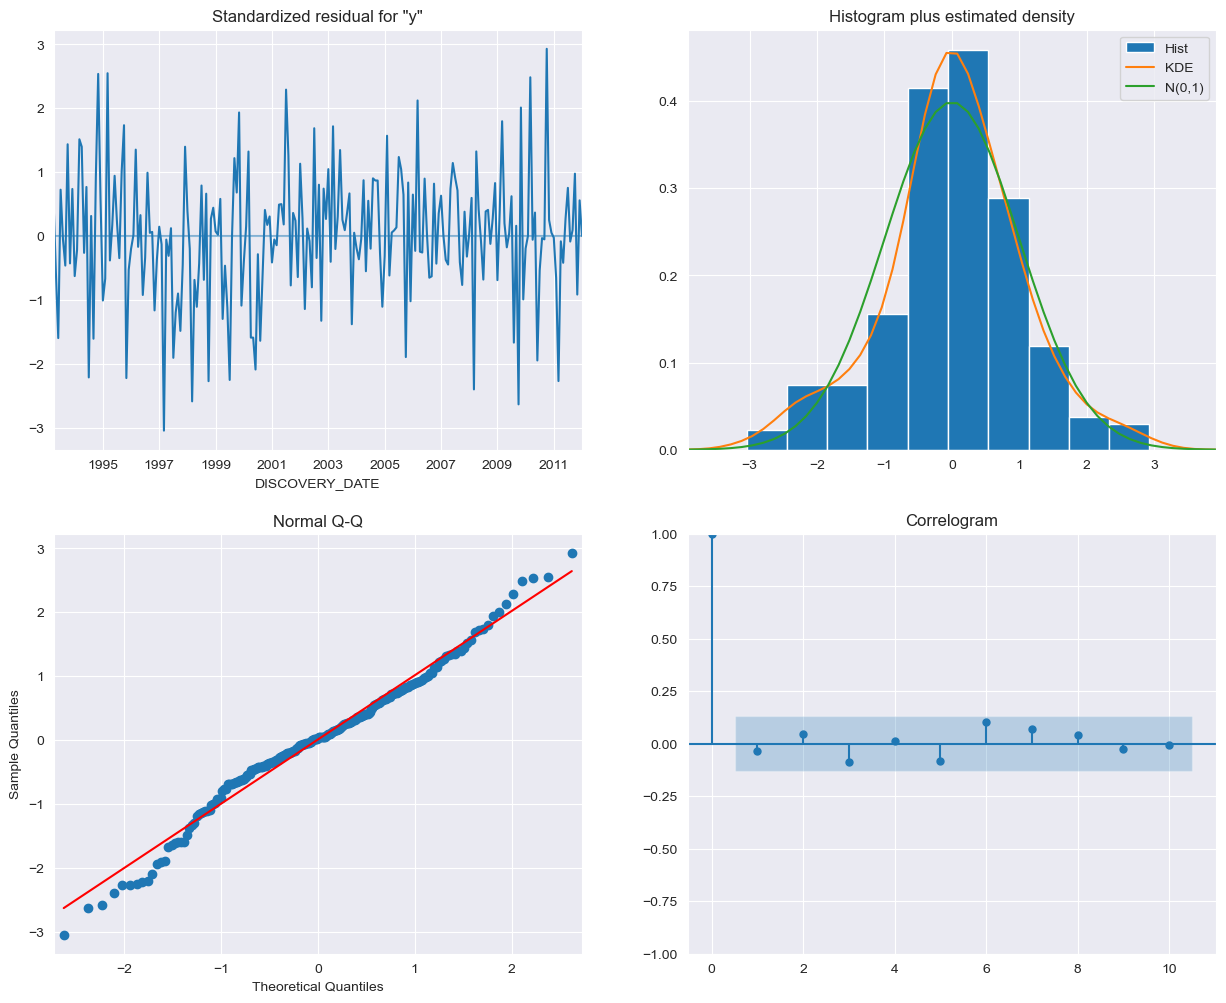

In [107]:
# Run model diagnostics
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

##Visualization

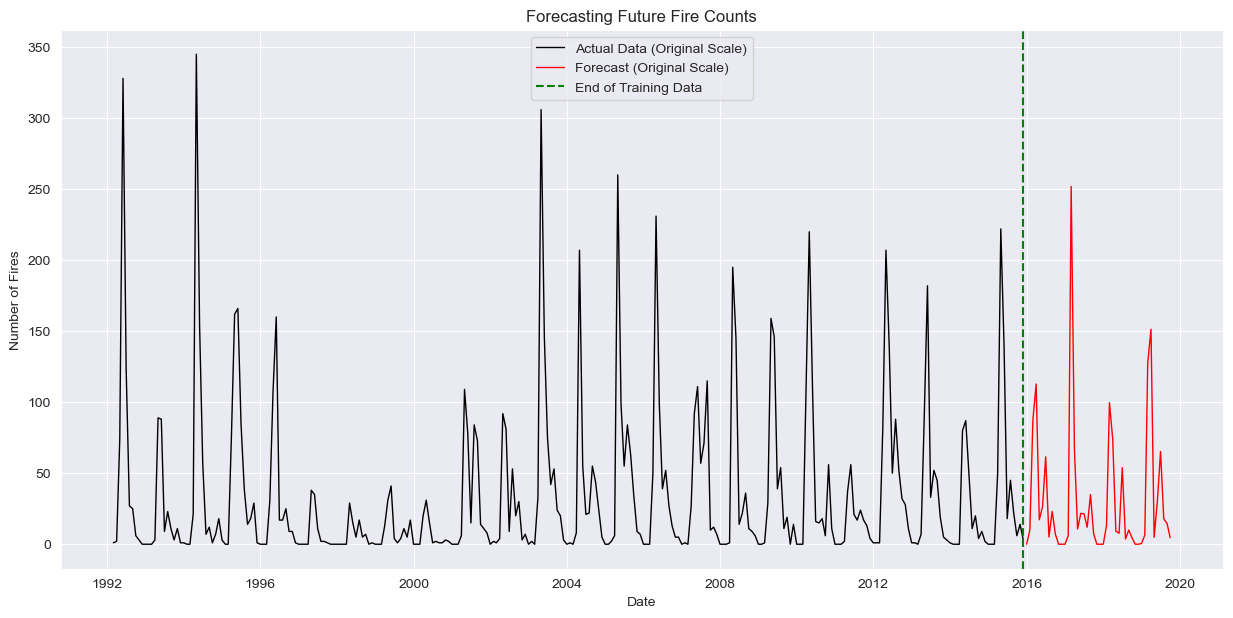

In [108]:
future_periods = 46

# Create a date range for the forecasted values
last_date = monthly_fire_counts_log.index[-1] #ignore warning it totally is accessing the index correctly
forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=future_periods, freq='MS')

# Plotting the actual data and the forecast
plt.figure(figsize=(15, 7))
plt.plot(monthly_fire_counts_log.index, np.expm1(monthly_fire_counts_log), label='Actual Data (Original Scale)', color='black', linewidth=1)
plt.plot(forecast_dates, forecasted_values, label='Forecast (Original Scale)', color='red', linewidth=1)
plt.axvline(x=last_date, color='green', linestyle='--', label='End of Training Data')
plt.legend()
plt.title("Forecasting Future Fire Counts")
plt.ylabel("Number of Fires")
plt.xlabel("Date")
plt.show()

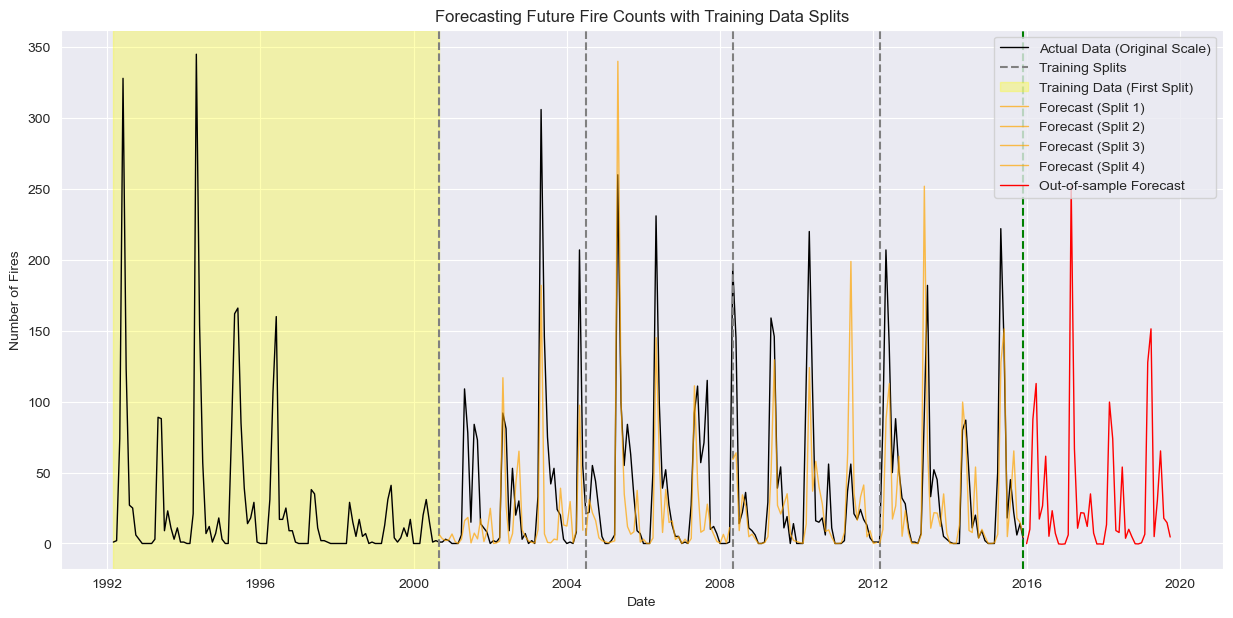

In [109]:
future_periods = 46  # Forecasting 46 months
forecasted_log = model_fit.get_forecast(steps=future_periods, exog=fourier_terms[-future_periods:]).predicted_mean
forecasted_values = np.expm1(forecasted_log)
forecast_dates = pd.date_range(start=monthly_fire_counts_log.index[-1] + pd.DateOffset(months=1), periods=future_periods, freq='MS')

# Plotting the actual data, the training data splits, and the forecast
plt.figure(figsize=(15, 7))
plt.plot(monthly_fire_counts_log.index, np.expm1(monthly_fire_counts_log), label='Actual Data (Original Scale)', color='black', linewidth=1)

# Plotting each split
split_dates = []
for i in range(n_splits):
    split_date = monthly_fire_counts_log.index[start_train_size + i * test_size]
    split_dates.append(split_date)
    if i == 0:
        plt.axvline(x=split_date, color='grey', linestyle='--', label='Training Splits')
    else:
        plt.axvline(x=split_date, color='grey', linestyle='--')

# Highlight the training data
plt.axvspan(monthly_fire_counts_log.index[0], split_dates[0], color='yellow', alpha=0.3, label='Training Data (First Split)')

# Plot the forecasts from cross-validation
for i, (pred, dates) in enumerate(zip(predictions, split_dates)):
    if i < n_splits:  # Don't plot the last split's forecast to avoid overlap with the out-of-sample forecast
        plt.plot(pd.date_range(start=dates, periods=len(pred), freq='MS'), pred, label=f'Forecast (Split {i+1})', color='orange', linewidth=1, alpha=0.7)

# Plot the out-of-sample forecast
plt.plot(forecast_dates, forecasted_values, label='Out-of-sample Forecast', color='red', linewidth=1)

plt.legend()
plt.title("Forecasting Future Fire Counts with Training Data Splits")
plt.axvline(x=last_date, color='green', linestyle='--', label='End of Training Data')
plt.ylabel("Number of Fires")
plt.xlabel("Date")
plt.show()